In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.6 MB/s eta 0:00:00


Davies-Bouldin Index: 0.5221946320383393


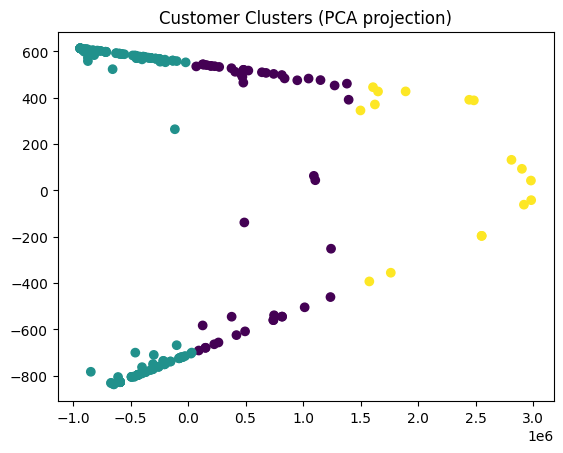

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

customer_transactions = transactions_df.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()

customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')

customer_data.fillna(0, inplace=True)

scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])


similarity_matrix = np.dot(customer_features, customer_features.T)
threshold = 0.2
edges = np.argwhere(similarity_matrix > threshold)


edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(customer_features, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)


class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


model = GCN(in_channels=customer_features.shape[1], out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(20000):
    optimizer.zero_grad()
    out = model(data)
    loss = out.mean()
    loss.backward()
    optimizer.step()

embeddings = model(data).detach().numpy()

kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(embeddings)

db_index = davies_bouldin_score(embeddings, labels)
print(f'Davies-Bouldin Index: {db_index}')

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels, cmap='viridis')
plt.title('Customer Clusters (PCA projection)')
plt.show()

# Save clusters in a CSV file
customer_data['Cluster'] = labels
customer_data.to_csv('Customer_Clusters.csv', index=False)

Number of clusters: 2, Davies-Bouldin Index: 0.5528784285550671
Number of clusters: 3, Davies-Bouldin Index: 0.4727637829893407
Number of clusters: 4, Davies-Bouldin Index: 0.4279068097049024
Number of clusters: 5, Davies-Bouldin Index: 0.4274135324428453
Number of clusters: 6, Davies-Bouldin Index: 0.45361535196115305
Number of clusters: 7, Davies-Bouldin Index: 0.49729483528746726
Number of clusters: 8, Davies-Bouldin Index: 0.4565620093492889
Number of clusters: 9, Davies-Bouldin Index: 0.5179875277449523
Best number of clusters: 5, Best Davies-Bouldin Index: 0.4274135324428453
Davies-Bouldin Index: 0.4303281589468476
Silhouette Score: 0.6283851265907288


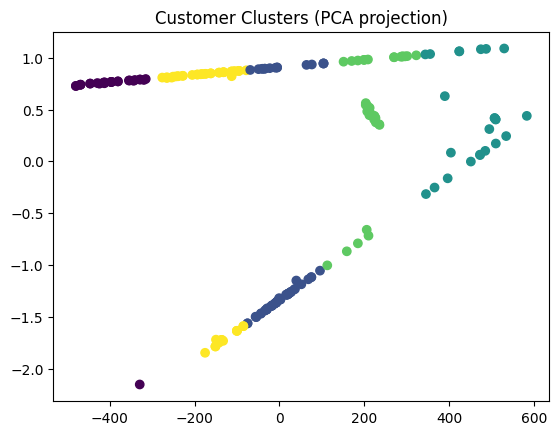

Cluster Report:
Number of Clusters: 5
Davies-Bouldin Index: 0.4303281589468476
Silhouette Score: 0.6283851265907288
Cluster Sizes: [28 64 24 35 49]
Cluster Centers: [[-3.9764020e+02  6.5978378e-01]
 [ 2.6238248e+00 -8.0900580e-01]
 [ 4.5753140e+02  4.3478799e-01]
 [ 2.2261668e+02  4.9083987e-01]
 [-1.5931288e+02  1.1561399e-01]]


In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

customer_transactions = transactions_df.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)
scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])


similarity_matrix = np.dot(customer_features, customer_features.T)
threshold = 0.5
edges = np.argwhere(similarity_matrix > threshold)

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(customer_features, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels=customer_features.shape[1], out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = out.mean()
    loss.backward()
    optimizer.step()

embeddings = model(data).detach().numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

best_db_index = float('inf')
best_n_clusters = 0

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_embeddings)
    db_index = davies_bouldin_score(reduced_embeddings, labels)
    print(f'Number of clusters: {n_clusters}, Davies-Bouldin Index: {db_index}')

    if db_index < best_db_index:
        best_db_index = db_index
        best_n_clusters = n_clusters

print(f'Best number of clusters: {best_n_clusters}, Best Davies-Bouldin Index: {best_db_index}')

kmeans = KMeans(n_clusters=best_n_clusters)
labels = kmeans.fit_predict(reduced_embeddings)

db_index = davies_bouldin_score(reduced_embeddings, labels)
silhouette_avg = silhouette_score(reduced_embeddings, labels)
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

cluster_centers = kmeans.cluster_centers_

cluster_sizes = np.bincount(labels)

pca_2d = PCA(n_components=2)
pca_embeddings = pca_2d.fit_transform(reduced_embeddings)

plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels, cmap='viridis')
plt.title('Customer Clusters (PCA projection)')
plt.show()

customer_data['Cluster'] = labels
customer_data.to_csv('Customer_Clusters.csv', index=False)

report = {
    'Number of Clusters': best_n_clusters,
    'Davies-Bouldin Index': db_index,
    'Silhouette Score': silhouette_avg,
    'Cluster Sizes': cluster_sizes,
    'Cluster Centers': cluster_centers
}

print("Cluster Report:")
for key, value in report.items():
    print(f"{key}: {value}")